In [1]:
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import train_test_split
    from sklearn_pandas import DataFrameMapper
    from sklearn import metrics
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.preprocessing import LabelBinarizer
    from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
    from sklearn.decomposition import PCA
    from sklearn.model_selection import GridSearchCV
    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.*")
    print("Se importó correctamente")
except Exception as e:
    print(f"Error al importar dependencias: {e}")

Se importó correctamente


* Al tener el Data Set repartido en 4 archivos diferentes segun la plataforma donde se produjeron las ventas, paso a unificar todo en un mismo DataFrame

In [2]:
import pandas as pd
import os

# Ruta a la carpeta que contiene los archivos
ruta_carpeta = "./csv"

# Lista de archivos que deseas concatenar
archivos_csv = ["fravega.csv", "ecommerce.csv", "mercadolibre.csv", "megatone.csv"]

# Leer los archivos con el delimitador adecuado y almacenarlos en una lista de DataFrames
dfs = [pd.read_csv(os.path.join(ruta_carpeta, archivo), encoding='latin1', delimiter=';') for archivo in archivos_csv]

# Concatenar los DataFrames en uno solo
sales = pd.concat(dfs, ignore_index=True)

sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA RETIRO OCA,COD. PRODUCTO,CANTIDAD,PRODUCTO,DTO %,FECHA COMPRA,PROVINCIA,LOCALIDAD,PLATAFORMA
2391,1.0,97085432,22/4/2022,1-14-15-003,2.0,NaN,0.0,18/4/2022,SANTA CRUZ,Río turbio,mercadolibre
3821,1.0,ANDREANI,3/11/2022,1-14-15-003,1.0,NaN,NaN,2/11/2022,ENTRE RÍOS,Nogoyá,mercadolibre
411,1,NaN,3/8/2023,1-12-38-006,1,COLCHÓN L. DA VINCI TRADICIONAL 140CMX190CM,0,20/7/2023,MENDOZA,Colonia Segovia,fravega
8129,1,96905429,21/4/2022,1-11-02-002,1.0,COLCHÓN L. SUPER CONFORT TRADICIONAL 80CMX190CM,NaN,8/4/2022,SANTA FE,ROSARIO,megatone
10165,1,105660841,14/4/2023,NaN,1.0,COLCHÓN L. ROMA TRADICIONAL 80CMX190CM,4,8/4/2023,SAN LUIS,VILLA MERCEDES,megatone


## Listado de variables 

#### Variables de entrada

* VALOR PRED.: Representa el valor del bulto.
* ORDEN DE RETIRO: Nro de orden por la cual la empresa identifica cada venta
* FECHA RETIRO OCA: Fecha donde OCA retira el producto
* COD. PRODUCTO: Identificador único de cada producto.
* PRODUCTO: Descripción del producto
* DTO %: Descuento aplicado en cada venta.
* FECHA COMPRA: Fecha en la que se realizó la compra del producto
* PROVINCIA: Nombre de la provincia donde se produjo de la venta
* LOCALIDAD: Nombre de la localidad donde se produjo de la venta
* PLATAFORMA: Canal o medio donde se produjo la venta.

#### Variable de salida: 

* CANTIDAD: representa el número de unidades vendidas por producto en una transacción

#### Reorganizo las columnas en el orden deseado

In [3]:
orden_columnas = [
    'VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA COMPRA', 'FECHA RETIRO OCA','COD. PRODUCTO', 'PRODUCTO', 'DTO %', 'PROVINCIA', 'LOCALIDAD', 'PLATAFORMA',
    'CANTIDAD'
]

# Reorganizar el DataFrame
sales = sales[orden_columnas]

# Mostrar las primeras filas del DataFrame reorganizado
print("Columnas reorganizadas:")
sales.sample(5)

Columnas reorganizadas:


,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
5167,1.0,NaN,23/4/2023,4/5/2023,1-23-15-005,PROMO 2 CONJUNTOS L. DALI TRADICIONAL 90CMX190CM,NaN,CAPITAL FEDERAL,Belgrano,mercadolibre,1.0
7641,1,94001539,29/11/2021,30/11/2021,NaN,CONJUNTO L. ROMA TRADICIONAL 140CMX190CM,0,SANTA FE,ROSARIO,megatone,1.0
6436,1.0,NaN,18/7/2023,26/7/2023,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,NaN,CAPITAL FEDERAL,Palermo,mercadolibre,1.0
9486,1,101819995,2/11/2022,4/11/2022,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,4,CÓRDOBA,SANTA ROSA DE CALAMUCHITA,megatone,1.0
1421,1,92658043,3/10/2021,5/10/2021,NaN,PROMO 2 COLCHONES L.SANZIO 80CMX190XM,"$ 0,00",BUENOS AIRES,Presidente Derqui,ecommerce,1


## Análisis detallado de un conjunto de variables

La variable CANTIDAD representa el número de unidades vendidas por transacción. Es la variable objetivo de este análisis, ya que el modelo buscará predecir su valor en función de las características del dataset.

Predecir CANTIDAD permitirá:

* Identificar tendencias de venta.
* Optimizar la planificación de inventarios.
* Mejorar la estrategia de ventas y promociones.

### Estadísticas descriptivas de la variable de salida

In [4]:
print("Estadísticas descriptivas de 'CANTIDAD':")
print(sales['CANTIDAD'].describe())

Estadísticas descriptivas de 'CANTIDAD':
count     11103
unique       15
top           1
freq       8976
Name: CANTIDAD, dtype: int64


In [5]:
# Convierto la columna 'CANTIDAD' a numérico, convirtiendo valores no válidos a NaN
sales['CANTIDAD'] = pd.to_numeric(sales['CANTIDAD'], errors='coerce')
# Reemplazo los valores NaN con 1
sales['CANTIDAD'] = sales['CANTIDAD'].fillna(1)
# Convierto la columna a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)

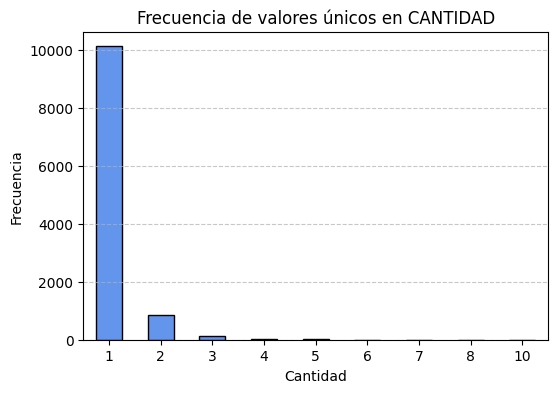

In [6]:
# Frecuencia de valores únicos en 'CANTIDAD'
frecuencia_cantidad = sales['CANTIDAD'].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(6, 4))
frecuencia_cantidad.plot(kind='bar', color='cornflowerblue', edgecolor='black')
plt.title('Frecuencia de valores únicos en CANTIDAD', fontsize=12)
plt.xlabel('Cantidad', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



## EDA, Limpieza y preprocesamiento

* Verificación de valores nulos en variable COD PRODUCTO y PRODUCTO:

In [7]:
# Contar nulos y valores vacíos en 'COD. PRODUCTO'
nulos_o_vacios_cod_producto = sales['COD. PRODUCTO'].isna().sum() + sales['COD. PRODUCTO'].eq('').sum()

# Contar nulos y valores vacíos en 'PRODUCTO'
nulos_o_vacios_producto = sales['PRODUCTO'].isna().sum() + sales['PRODUCTO'].str.strip().eq('').sum()

print(f"Valores nulos o vacíos en 'COD. PRODUCTO': {nulos_o_vacios_cod_producto}")
print(f"Valores nulos o vacíos en 'PRODUCTO': {nulos_o_vacios_producto}")

Valores nulos o vacíos en 'COD. PRODUCTO': 3298
Valores nulos o vacíos en 'PRODUCTO': 2198


- Tratamiento para determinar que para algunos de los COD PRODUCTOS detectados sin descripcion de Producto tenga en algun otro lado del data set la descripcion. Lo mismo para aquellas Productos detectados sin Cod Producto. 
El objetivo de esto es rellenar valores que se detectan nulos en las columnas de COD PRODUCTO y PRODUCTO.

In [8]:
# Crear un mapeo único entre COD PRODUCTO y PRODUCTO
mapeo_cod_producto = sales[['COD. PRODUCTO', 'PRODUCTO']].drop_duplicates()

print("Mapa único entre códigos y productos:")
mapeo_cod_producto.shape

Mapa único entre códigos y productos:


(478, 2)

In [9]:
# Convertir el mapeo a un diccionario para facilitar su uso
mapeo_dict = mapeo_cod_producto.set_index('PRODUCTO')['COD. PRODUCTO'].to_dict()

# Completar o corregir la columna 'COD PRODUCTO'
sales['COD. PRODUCTO'] = sales['PRODUCTO'].map(mapeo_dict)

In [10]:
# Detectar inconsistencias entre 'COD PRODUCTO' y 'PRODUCTO'
inconsistencias = sales[sales['PRODUCTO'] != sales['COD. PRODUCTO'].map(mapeo_dict)]

In [11]:
sales['PRODUCTO'] = sales['COD. PRODUCTO'].map({v: k for k, v in mapeo_dict.items()})


In [12]:
sales.sample(5)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
8014,1,96516587,17/3/2022,23/3/2022,1-10-02-002,ALMOHADAS L.PLACA 80CM,NaN,SANTIAGO DEL ESTERO,SANTIAGO DEL ESTERO,megatone,1
5527,1.0,NaN,8/5/2023,9/5/2023,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,BUENOS AIRES,Jose Marmol,mercadolibre,1
4403,1.0,NaN,2/1/2023,5/1/2023,NaN,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,CÓRDOBA,Córdoba,mercadolibre,1
4718,1.0,105378013,25/3/2023,30/3/2023,1-22-41-007,CONJUNTO L. MARINERA TRAD RESORTE 90CMX190CM S...,NaN,SANTA FE,Berabevú,mercadolibre,2
2614,1.0,98083462,30/5/2022,1/6/2022,1-11-16-017,NaN,10.0,CHUBUT,Comodoro Rivadavia,mercadolibre,1


In [13]:
faltantes_codproducto = sales[sales['COD. PRODUCTO'].isna()]
# Obtener los valores únicos de la columna 'PRODUCTO'
valores_unicos_producto = faltantes_codproducto['PRODUCTO'].unique()

print(valores_unicos_producto)

['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [14]:
productos_con_nan = sales[sales['COD. PRODUCTO'].isna()]

# Mostrar valores únicos de la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN
valores_producto_nan = productos_con_nan['PRODUCTO'].unique()

print("Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:")
print(valores_producto_nan)

Valores únicos en la columna 'PRODUCTO' donde 'COD PRODUCTO' es NaN:
['CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM']


In [15]:
sales.loc[sales['COD. PRODUCTO'].isna(), 'COD. PRODUCTO'] = '1-20-20-200'

In [16]:
sales.sample(2)

,VALOR PRED.,ORDEN DE RETIRO,FECHA COMPRA,FECHA RETIRO OCA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
2613,1.0,98082618,30/5/2022,3/6/2022,1-11-16-017,NaN,10.0,MENDOZA,Tunuyan,mercadolibre,1
5369,1.0,106449312,6/5/2023,9/5/2023,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,NaN,NEUQUÉN,zapala,mercadolibre,1


* Verificamos si quedan filas donde 'COD PRODUCTO' es nulo

In [17]:
sin_codproducto = sales[sales['COD. PRODUCTO'].isna()]
print("Filas con 'COD PRODUCTO' faltante:")
sin_codproducto.shape

Filas con 'COD PRODUCTO' faltante:


(0, 11)

In [18]:
# Mostrar filas donde 'PRODUCTO' es NaN
sin_producto = sales[sales['PRODUCTO'].isna()]
print("Filas con 'PRODUCTO' faltante:")
sin_producto.shape

Filas con 'PRODUCTO' faltante:


(2212, 11)

In [19]:
# Contar valores únicos en 'COD. PRODUCTO'
valores_unicos_cod_producto = sin_producto['COD. PRODUCTO'].unique()

# Contar la cantidad de valores únicos
cantidad_valores_unicos = len(valores_unicos_cod_producto)
print(valores_unicos_cod_producto)

['1-11-16-017']


In [20]:
sales.loc[sales['PRODUCTO'].isna() , 'PRODUCTO'] = 'Descripcion de producto pendiente a consultar al cliente'

In [21]:
# Contar valores nulos en cada columna
valores_nulos = sales.isna().sum()

print("Cantidad de valores nulos por columna:")
print(valores_nulos)

Cantidad de valores nulos por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %               6457
PROVINCIA             57
LOCALIDAD            247
PLATAFORMA             0
CANTIDAD               0
dtype: int64


* Limpieza y correccion de valores en las columnas. 

In [24]:
# Asignar el valor de 'PROVINCIA' a 'LOCALIDAD' donde 'LOCALIDAD' es nulo
sales['LOCALIDAD'] = sales['LOCALIDAD'].fillna(sales['PROVINCIA'])

# Asignar 'Descripcion faltante' donde 'COD. PRODUCTO' sea NaN
sales['COD. PRODUCTO'] = sales['COD. PRODUCTO'].fillna('Descripcion faltante')

#Convertir la columna 'DTO' a valores enteros
sales['DTO %'] = sales['DTO %'].replace(['$0,00', 0.0], '0').fillna('0')

In [25]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
VALOR PRED.          254
ORDEN DE RETIRO     3852
FECHA COMPRA          40
FECHA RETIRO OCA    1104
COD. PRODUCTO          0
PRODUCTO               0
DTO %                  0
PROVINCIA             57
LOCALIDAD             57
PLATAFORMA             0
CANTIDAD               0
dtype: int64


In [26]:
# Eliminar las columnas que no voy a utilizar
sales = sales.drop(columns=['VALOR PRED.', 'ORDEN DE RETIRO', 'FECHA RETIRO OCA'])
# Eliminar filas donde 'PROVINCIA' sea NaN
sales = sales.dropna(subset=['PROVINCIA'])
# Convertir la columna 'CANTIDAD' a enteros
sales['CANTIDAD'] = sales['CANTIDAD'].astype(int)
# Convertir la columna 'DTO %' a tipo numérico para reemplazar los valores que no son % de descuento sino monto en pesos
sales['DTO %'] = pd.to_numeric(sales['DTO %'], errors='coerce')
# Reemplazar valores de DTO % fuera del rango (negativos o mayores a 50) y nulos con 0
sales['DTO %'] = sales['DTO %'].apply(lambda x: 0 if pd.isna(x) or x > 50 or x < 0 else x)


In [23]:
# Eliminar filas donde 'FECHA COMPRA' sea NaN, REVISAR para buscar la fecha 
sales = sales.dropna(subset=['FECHA COMPRA'])

In [30]:
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], errors='coerce')

sales = sales.sort_values(by='FECHA COMPRA')

sales['FECHA COMPRA'] = sales['FECHA COMPRA'].ffill()  # Rellenar con el valor anterior
sales['FECHA COMPRA'] = sales['FECHA COMPRA'].bfill()  # Si no hay anterior, usar el siguiente

print(sales['FECHA COMPRA'].isna().sum(), "valores nulos restantes en 'FECHA COMPRA'")


0 valores nulos restantes en 'FECHA COMPRA'


In [31]:
sales.sample(5)

,FECHA COMPRA,COD. PRODUCTO,PRODUCTO,DTO %,PROVINCIA,LOCALIDAD,PLATAFORMA,CANTIDAD
10441,2023-05-09,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,4.0,BUENOS AIRES,Base Naval Mar Del Plata,megatone,1
1787,2021-11-04,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,ENTRE RÍOS,Paraná,ecommerce,1
2574,2022-05-30,1-11-16-017,Descripcion de producto pendiente a consultar ...,10.0,CÓRDOBA,Río Cuarto,mercadolibre,1
9247,2022-09-28,1-12-40-006,COLCHÓN L. ROMA TRADICIONAL 140CMX190CM,0.0,BUENOS AIRES,PARADA ROBLES,megatone,1
5776,2023-05-10,1-20-20-200,CONJUNTO L. MARBELLA TRADICIONAL 200CMX200CM,0.0,CHUBUT,Puerto Madryn,mercadolibre,1


In [33]:
# Verificar valores nulos restantes en todo el dataset
print("Valores nulos restantes por columna:")
print(sales.isna().sum())

Valores nulos restantes por columna:
FECHA COMPRA     0
COD. PRODUCTO    0
PRODUCTO         0
DTO %            0
PROVINCIA        0
LOCALIDAD        0
PLATAFORMA       0
CANTIDAD         0
dtype: int64


## A modo resumen un detalle de las transformaciones realizadas a las variables 

* Valor Pred : Eliminada ya que no aporta valor al modelo
* Orden de Retiro : Eliminada ya que no aporta valor al modelo, es un identificador de la venta
* Fecha retiro OCA: Eliminada ya que no aporta valor al modelo
* Fecha compra : El data set inical estaba ordenado por fecha, cuando algun registro no contaba con la misma se buscó insertar la mas cercana en el índice anterior.
* Cantidad: se convirtió a valor entero en todos sus casos.
* Cod. Producto: se rellenó los valores faltantes comparando la descripcion del producto en otras celdas que tenga el cod producto cargado.
* Producto: se rellenó los valores faltantes comparando el cod. producto en otras celdas que tenga la misma descripción del producto cargada. 
* DTO %: Algunos registros no tenian valor porcentual sino numérico, por lo que cuando se encontraba un valor mayor a 50 se insertó 0.
* Localidad: Se rellenó para los valores faltantes con el nombre de la provincia como valor genérico, posiblemente no aporte mucho valor al modelo.
* Provincia: Se eliminaron los registros que no contaban con provincia asignada


## Realizar un análisis individual de cada variable de entrada que será utilizada. A partir del mismo debería poder conocerse la distribución de los datos, si existen valores raros, su relación con la variable de salida, etc.

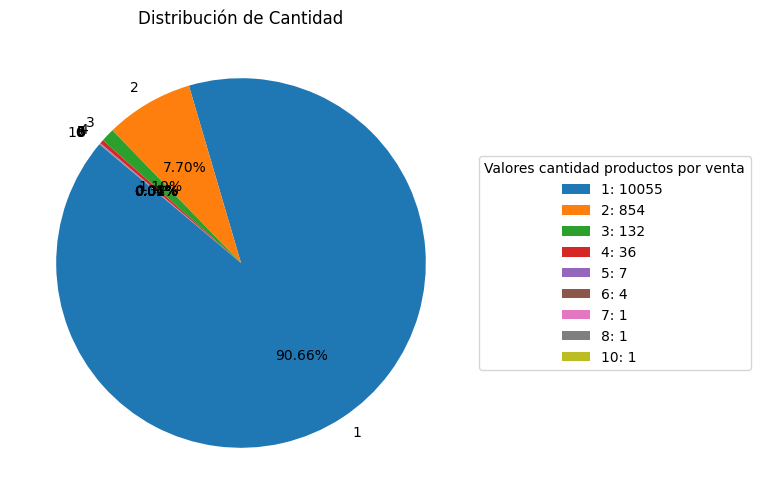

In [51]:
import matplotlib.pyplot as plt

# Filtrar valores no nulos y calcular frecuencia
cantidad_frecuencia = sales['CANTIDAD'].value_counts()

plt.figure(figsize=(6, 6))  # Ajustar tamaño del gráfico
wedges, texts, autotexts = plt.pie(
    cantidad_frecuencia, 
    labels=cantidad_frecuencia.index, 
    autopct='%2.2f%%', 
    startangle=140
)
leyenda = [f"{index}: {value} " for index, value in cantidad_frecuencia.items()]
plt.legend(
    wedges, 
    leyenda, 
    title="Valores cantidad productos por venta", 
    loc="center left", 
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.title('Distribución de Cantidad')
plt.show()



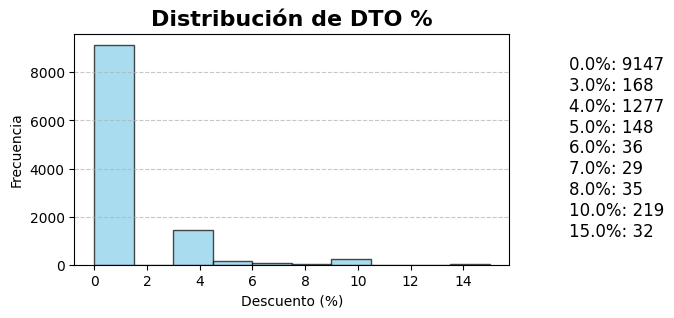

In [35]:
dto_frecuencia = sales['DTO %'].value_counts().sort_index()

plt.figure(figsize=(6, 3))
plt.hist(sales['DTO %'], bins=10, edgecolor='black', color='skyblue', alpha=0.7)
plt.title('Distribución de DTO %', fontsize=16, fontweight='bold')
plt.xlabel('Descuento (%)', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)

frecuencias_texto = "\n".join([f"{index}%: {value}" for index, value in dto_frecuencia.items()])
plt.gcf().text(0.95, 0.5, frecuencias_texto, fontsize=12, verticalalignment='center')
plt.subplots_adjust(right=0.85)

plt.show()

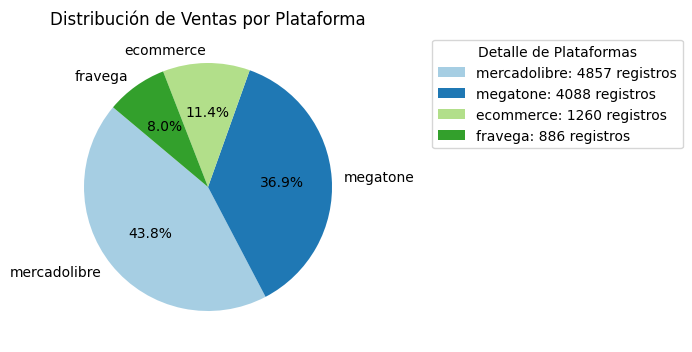

In [36]:
frecuencia_plataforma = sales['PLATAFORMA'].value_counts()

plt.figure(figsize=(4, 8))
plt.pie(
    frecuencia_plataforma,
    labels=frecuencia_plataforma.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Paired.colors
)
plt.title('Distribución de Ventas por Plataforma', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} registros" for index, value in frecuencia_plataforma.items()],
    title="Detalle de Plataformas",    
    loc="center left",
    bbox_to_anchor=(1.2, 0.8)  
)

plt.show()

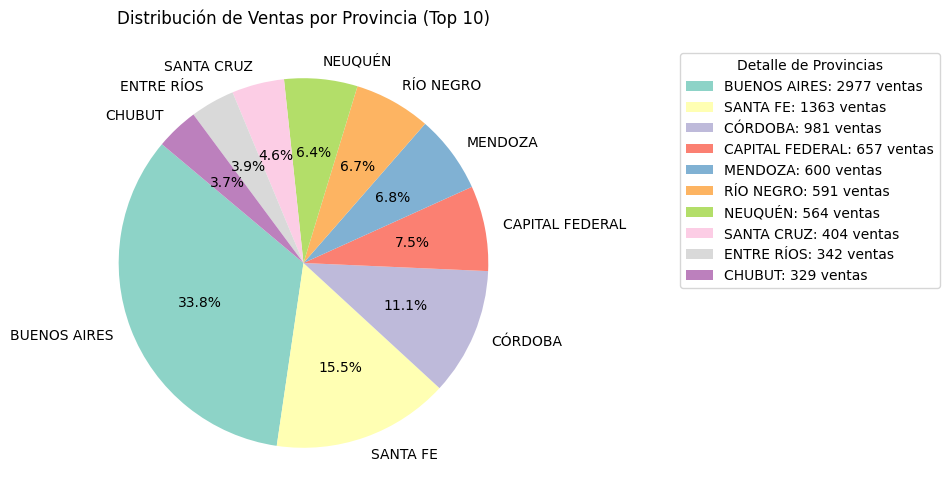

In [37]:
frecuencia_provincia = sales['PROVINCIA'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Provincia (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de Provincias",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()


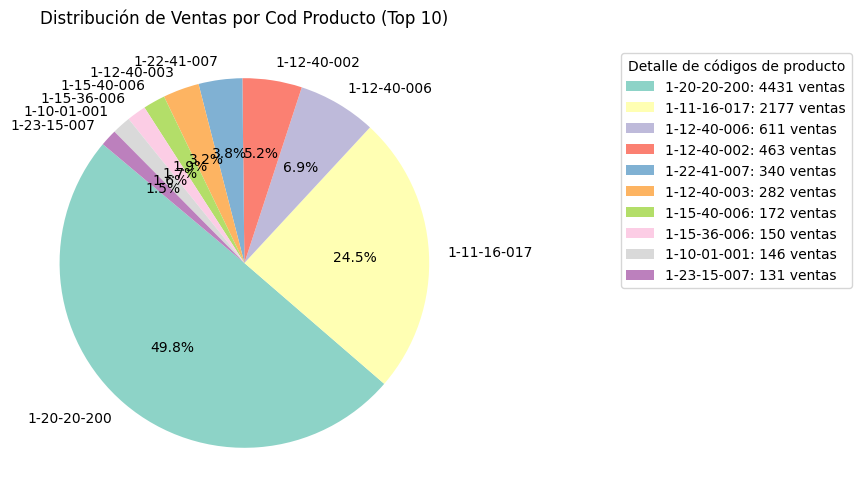

In [44]:
frecuencia_provincia = sales['COD. PRODUCTO'].value_counts().head(10)

plt.figure(figsize=(6, 6))
plt.pie(
    frecuencia_provincia,
    labels=frecuencia_provincia.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title('Distribución de Ventas por Cod Producto (Top 10)', fontsize=12)
plt.legend(
    labels=[f"{index}: {value} ventas" for index, value in frecuencia_provincia.items()],
    title="Detalle de códigos de producto",
    loc="center left", 
    bbox_to_anchor=(1.3, 0.7) 
)

plt.show()

## Transformaciones Fecha Compra

In [38]:
# Convertir 'FECHA COMPRA' a datetime especificando el formato exacto
sales['FECHA COMPRA'] = pd.to_datetime(sales['FECHA COMPRA'], format='%d/%m/%Y')

datetime64[ns]


In [39]:
# Crear columnas temporales
sales['AÑO'] = sales['FECHA COMPRA'].dt.year
sales['MES'] = sales['FECHA COMPRA'].dt.month
sales['SEMANA'] = sales['FECHA COMPRA'].dt.isocalendar().week
sales['DÍA'] = sales['FECHA COMPRA'].dt.day


     FECHA COMPRA   AÑO  MES  SEMANA  DÍA
9392   2002-10-27  2002   10      43   27
9853   2002-12-24  2002   12      52   24
7024   2021-04-15  2021    4      15   15
7025   2021-04-15  2021    4      15   15
7026   2021-04-16  2021    4      15   16


* Distribucion de ventas por mes

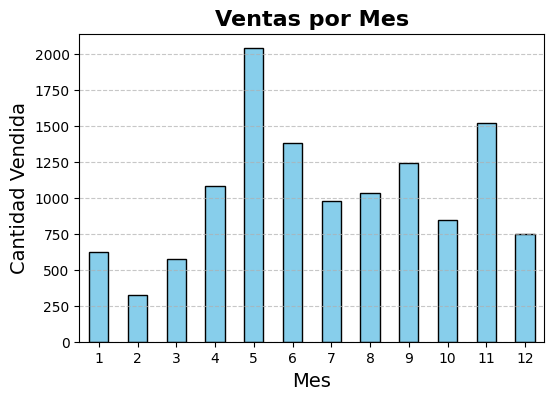

In [40]:
ventas_por_mes = sales.groupby('MES')['CANTIDAD'].sum()

plt.figure(figsize=(6, 4))
ventas_por_mes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Ventas por Mes', fontsize=16, fontweight='bold')
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# me falta hacer la matris de correlacion

In [45]:
# Aplicar One Hot Encoding a la columna 'PLATAFORMA'
# plataforma_dummies = pd.get_dummies(sales['PLATAFORMA'], prefix='', prefix_sep='')

# Asegurar que los valores sean 0 y 1 (aunque normalmente ya lo son con pandas.get_dummies)
# plataforma_dummies = plataforma_dummies.astype(int)

# Unir las columnas dummy al dataset original
# sales = pd.concat([sales, plataforma_dummies], axis=1)
# sales = sales.drop(columns=['PLATAFORMA'])
# sales.sample(5)

# Hipótesis sobre los datos

# Modelado